# Analysis of raw data from tactile and vision

1. Test preprocessing and make changes
2. Number of spikes

In [130]:
import os
import numpy as np

In [131]:
start_end_dir = '/datasets/eventdata/batch2/traj_start_ends/'
some_order = os.listdir(start_end_dir)


In [132]:
start_time_holder = list()
for i in some_order:
    load_file = np.loadtxt(start_end_dir+'/'+i)
    start_time_holder.append(load_file[0])
#print(some_order)
#print(start_time_holder)

In [133]:
argsorted = np.argsort(np.array(start_time_holder))
for i in range(len(argsorted)):
    print(some_order[argsorted[i]])

109-a_soymilk_01.startend
109-a_soymilk_02.startend
109-a_soymilk_03.startend
109-a_soymilk_04.startend
109-a_soymilk_05.startend
109-a_soymilk_06.startend
109-a_soymilk_07.startend
109-a_soymilk_08.startend
109-a_soymilk_09.startend
109-a_soymilk_10.startend
109-a_soymilk_11.startend
109-a_soymilk_12.startend
109-a_soymilk_13.startend
109-a_soymilk_14.startend
109-a_soymilk_15.startend
109-a_soymilk_16.startend
109-a_soymilk_17.startend
109-a_soymilk_18.startend
109-a_soymilk_19.startend
109-a_soymilk_20.startend
109-b_soymilk_01.startend
109-b_soymilk_02.startend
109-b_soymilk_03.startend
109-b_soymilk_04.startend
109-b_soymilk_05.startend
109-b_soymilk_06.startend
109-b_soymilk_07.startend
109-b_soymilk_08.startend
109-b_soymilk_09.startend
109-b_soymilk_10.startend
109-b_soymilk_11.startend
109-b_soymilk_12.startend
109-b_soymilk_13.startend
109-b_soymilk_14.startend
109-b_soymilk_15.startend
109-b_soymilk_16.startend
109-b_soymilk_17.startend
109-b_soymilk_18.startend
109-b_soymil

In [134]:
# batch2_order = {
#     'pepsi':[],
#     'tuna':[],
#     'coffee':[],
#     'soy':[]
# }
# argsorted = np.argsort(np.array(start_time_holder))
# for i in range(len(argsorted)):
#     if 'pepsi' in some_order[argsorted[i]]:
#         print(some_order[argsorted[i]])
#         batch2_order['pepsi'].append(some_order[argsorted[i]][-11:-9])
#     elif 'tuna' in some_order[argsorted[i]]:
#         batch2_order['tuna'].append(some_order[argsorted[i]][-11:-9])
#     elif 'coffee' in some_order[argsorted[i]]:
#         batch2_order['coffee'].append(some_order[argsorted[i]][-11:-9])
#     elif 'soy' in some_order[argsorted[i]]:
#         batch2_order['soy'].append(some_order[argsorted[i]][-11:-9])    

In [135]:
# print("\n---------------------------\n")
# for i in range(len(argsorted)):
#     if some_order[argsorted[i]][0:-12] == "107-a_pepsi_bottle":
#         print(some_order[argsorted[i]])

In [136]:
import pandas as pd
import numpy as np
import os
import logging
import datetime
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import Parallel, delayed
from pathlib import Path
from collections import namedtuple

In [137]:
selections = {  # index, offset, length
    "full": [1, 0.0, 8.5],
    "reaching": [1, 0.0, 2.0],
    "grasp": [3, 0.0, 4.0],
    "lift": [4, 0.0, 0.75],
    "hold": [4, 2.0, 1.25],
    "lift_hold": [4, 0.0, 2.0],
    "grasp_lift": [3, 0.0, 4.75],
    "grasp_lift_hold": [3, 0.0, 6.5]
}

In [138]:
Trajectory = namedtuple(
    "Trajectory", ["start", "reaching", "reached", "grasping", "lifting", "holding"]
)

In [139]:
def read_trajectory(trajectory_path, obj_name, start_time=None, zeroed=False):
    """Reads the trajectory from path, Returns a Trajectory."""
    obj_path = Path(trajectory_path) / f"{obj_name}.startend"
    with open(obj_path, "r") as f:
        timings = list(map(float, f.read().split(" ")))
        if start_time is not None:
            delta = start_time - timings[0]
            timings = [t + delta for t in timings]
        if zeroed:
            start_time = timings[0]
            timings = [t - start_time for t in timings]
        return Trajectory(*timings)

In [140]:
def read_tactile_file(tactile_path, obj_name):
    """Reads a tactile file from path. Returns a pandas dataframe."""
    obj_path = Path(tactile_path) / f"{obj_name}.tact"
    df = pd.read_csv(obj_path, delimiter=' ', names=['polarity', 'cell_index', 'timestamp_sec', 'timestamp_nsec'], dtype=int)
    df = df.assign(timestamp=df.timestamp_sec + df.timestamp_nsec/1000000000)
    df = df.drop(['timestamp_sec', 'timestamp_nsec'], axis=1)
    return df

In [141]:
class TactileData:
    def __init__(self, obj_name, selection):
        assert selection in selections
        self.obj_name = obj_name
        self.trajectory = read_trajectory(trajectory_path, obj_name)
        self.df = read_tactile_file(tactile_path, obj_name)

        traj_start, offset, self.T = selections[selection]
        self.start_t = self.trajectory[traj_start] + offset
        self.threshold = 1

    def binarize(self, bin_duration):
        bin_number = int(np.floor(self.T / bin_duration))
        data_matrix = np.zeros([80, 2, bin_number], dtype=int)

        pos_df = self.df[self.df.polarity == 1]
        neg_df = self.df[self.df.polarity == 0]

        end_t = self.start_t + bin_duration
        count = 0

        init_t = self.start_t

        while end_t <= self.T + init_t:  # start_t <= self.T
            _pos_count = pos_df[
                ((pos_df.timestamp >= self.start_t) & (pos_df.timestamp < end_t))
            ]
            _pos_selective_cells = _pos_count.cell_index.value_counts() > self.threshold
            if len(_pos_selective_cells):
                data_matrix[
                    _pos_selective_cells[_pos_selective_cells].index.values - 1,
                    0,
                    count,
                ] = 1

            _neg_count = neg_df[
                ((neg_df.timestamp >= self.start_t) & (neg_df.timestamp < end_t))
            ]
            _neg_selective_cells = _neg_count.cell_index.value_counts() > self.threshold
            if len(_neg_selective_cells):
                data_matrix[
                    _neg_selective_cells[_neg_selective_cells].index.values - 1,
                    1,
                    count,
                ] = 1
            self.start_t = end_t
            end_t += bin_duration
            count += 1

        data_matrix = np.delete(data_matrix, [16, 48], 0)
        return data_matrix

In [153]:
tact.df[(tact.df.cell_index != 16) & (tact.df.cell_index != 48)].shape

(20175, 3)

In [154]:
tact.df.shape

(20546, 3)

In [142]:
# batch2
list_of_objects2 = [
    "107-a_pepsi_bottle",
    "107-b_pepsi_bottle",
    "107-c_pepsi_bottle",
    "107-d_pepsi_bottle",
    "107-e_pepsi_bottle",
    "108-a_tuna_fish_can",
    "108-b_tuna_fish_can",
    "108-c_tuna_fish_can",
    "108-d_tuna_fish_can",
    "108-e_tuna_fish_can",
    "109-a_soymilk",
    "109-b_soymilk",
    "109-c_soymilk",
    "109-d_soymilk",
    "109-e_soymilk",
    "110-a_coffee_can",
    "110-b_coffee_can",
    "110-c_coffee_can",
    "110-d_coffee_can",
    "110-e_coffee_can",
]

In [143]:
obj_name = list_of_objects2[0] +'_01'
trajectory_path = '/datasets/eventdata/batch2/traj_start_ends/'
trajectory = read_trajectory(trajectory_path, obj_name)

In [144]:
tactile_path = '/datasets/eventdata/batch2/aces_recordings/'
df = read_tactile_file(tactile_path, obj_name)

In [145]:
tact = TactileData(obj_name, selection="grasp_lift_hold")

In [157]:
tact.df[tact.df.cell_index < 40].shape

(13111, 3)

In [151]:
np.sort( tact.df.cell_index.unique() )

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [147]:
tact.df[tact.df.polarity==0].shape

(10810, 3)

In [51]:
a = tact.binarize(bin_duration=0.02)

In [52]:
tact.df.tail()

,polarity,cell_index,timestamp
20541,1,78,1.579159e+09
20542,1,36,1.579159e+09
20543,1,3,1.579159e+09
20544,1,35,1.579159e+09
20545,0,57,1.579159e+09


In [53]:
tact.df.timestamp

0        1.579159e+09
1        1.579159e+09
2        1.579159e+09
3        1.579159e+09
4        1.579159e+09
             ...     
20541    1.579159e+09
20542    1.579159e+09
20543    1.579159e+09
20544    1.579159e+09
20545    1.579159e+09
Name: timestamp, Length: 20546, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa763b42320>]],
      dtype=object)

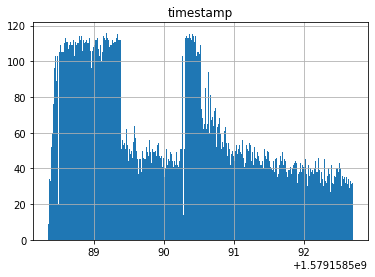

In [54]:
tact.df.hist(column='timestamp', bins=325)

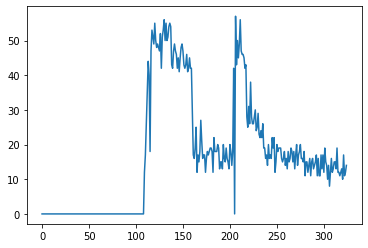

In [55]:
plt.plot(np.sum( np.sum(a, axis=0), axis=0 ))

In [56]:
video_path = '/datasets/eventdata/batch2/prophesee_recordings/'

In [57]:
class CameraData:
    def __init__(self, obj_name, selection="full"):
        # propophesee hyperparameters
        self.c = 2
        self.w = 200
        self.h = 250
        x0 = 180
        y0 = 0

        file_path = video_path + obj_name  # + ".start" # _td.mat
        start_time = float(open(file_path + ".start", "r").read())

        self.trajectory = read_trajectory(
            trajectory_path, obj_name, start_time=start_time, zeroed=True
        )

        traj_start, offset, self.T = selections[selection]
        self.start_t = self.trajectory[traj_start] + offset

        td_data = loadmat(file_path + "_td.mat")["td_data"]
        df = pd.DataFrame(columns=["x", "y", "polarity", "timestamp"])
        a = td_data["x"][0][0]
        b = td_data["y"][0][0]
        mask_x = (a >= 230) & (a < 430)
        mask_y = (b >= 100)
        a1 = a[mask_x & mask_y] - 230
        b1 = b[mask_x & mask_y] - 100
        df.x = a1.flatten()
        df.y = b1.flatten()
        df.polarity = td_data["p"][0][0][mask_x & mask_y].flatten()
        df.timestamp = (
            td_data["ts"][0][0][mask_x & mask_y].flatten() / 1000000.0
        )

        self.df = df
        self.threshold = 1

    def binarize(self, bin_duration):
        bin_number = int(np.floor(self.T / bin_duration))
        data_matrix = np.zeros([self.c, self.w, self.h, bin_number], dtype=int)

        pos_df = self.df[self.df.polarity == 1]
        neg_df = self.df[self.df.polarity == -1]

        end_t = self.start_t + bin_duration
        count = 0

        init_t = self.start_t

        while end_t <= self.T + init_t:  # start_t <= self.T
            _pos_count = pos_df[
                ((pos_df.timestamp >= self.start_t) & (pos_df.timestamp < end_t))
            ]
            b = pd.DataFrame(index=_pos_count.index)
            b = b.assign(
                xy=_pos_count["x"].astype(str) + "_" + _pos_count["y"].astype(str)
            )
            mask = b.xy.value_counts() >= self.threshold
            some_array = mask[mask].index.values.astype(str)
            xy = np.array(list(map(lambda x: x.split("_"), some_array))).astype(int)
            if xy.shape[0] > 0:
                data_matrix[0, xy[:, 0], xy[:, 1], count] = 1

            _neg_count = neg_df[
                ((neg_df.timestamp >= self.start_t) & (neg_df.timestamp < end_t))
            ]
            b = pd.DataFrame(index=_neg_count.index)
            b = b.assign(
                xy=_neg_count["x"].astype(str) + "_" + _neg_count["y"].astype(str)
            )
            mask = b.xy.value_counts() >= self.threshold
            some_array = mask[mask].index.values.astype(str)
            xy = np.array(list(map(lambda x: x.split("_"), some_array))).astype(int)
            if xy.shape[0] > 0:
                data_matrix[1, xy[:, 0], xy[:, 1], count] = 1

            self.start_t = end_t
            end_t += bin_duration
            count += 1

        data_matrix = np.swapaxes(data_matrix, 1, 2)

        return data_matrix

In [58]:
cam = CameraData(obj_name, selection="grasp_lift_hold")

In [59]:
cam.df.head()

,x,y,polarity,timestamp
0,199,114,-1,0.000017
1,60,15,-1,0.000038
2,191,130,-1,0.000070
3,56,6,1,0.000103
4,105,105,1,0.000285


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa763262be0>]],
      dtype=object)

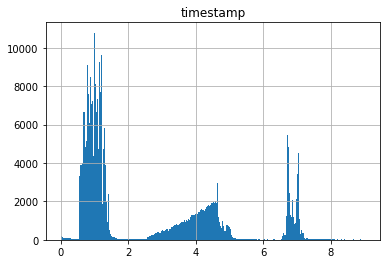

In [60]:
cam.df.hist(column='timestamp', bins=425)

In [61]:
a = cam.binarize(0.02)

In [62]:
a.shape

(2, 250, 200, 325)

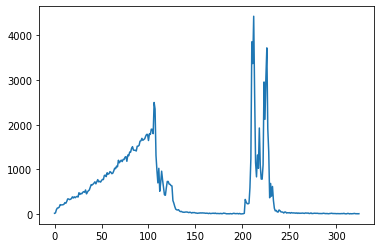

In [63]:
plt.plot( np.sum( np.sum( np.sum(a, axis=0), axis=0 ), axis=0) )

In [161]:
### count number ok spikes
tact_neg_spikes = []
tact_pos_spikes = []
cam_neg_spikes = []
cam_pos_spikes = []

tact_neg_spikes_left = []
tact_pos_spikes_left = []
cam_neg_spikes_left = []
cam_pos_spikes_left = []

argsorted = np.argsort(np.array(start_time_holder))
for i in range(len(argsorted)):
    file_name = some_order[argsorted[i]][:-9]
    print(file_name)
    #tact_glh = TactileData(file_name, selection="grasp_lift_hold")
    #cam_glh = CameraData(file_name, selection="grasp_lift_hold")

    tact = TactileData(file_name, selection="full")
    cam = CameraData(file_name, selection="full")
    
    mask = tact.df.cell_index < 40

    tact_neg_spikes.append(tact.df[(tact.df.polarity == 0) & mask].shape[0])
    tact_pos_spikes.append(tact.df[(tact.df.polarity == 1) & mask].shape[0])
    
    tact_neg_spikes_left.append(tact.df[(tact.df.polarity == 0) & (~mask)].shape[0])
    tact_pos_spikes_left.append(tact.df[(tact.df.polarity == 1) & (~mask)].shape[0])

    #tact_neg_spikes_glh.append(tact_glh.df[tact_glh.df == 0].shape[0])
    #tact_pos_spikes_glh.append(tact_glh.df[tact_glh.df == 1].shape[0])

#     cam_neg_spikes.append(cam.df[tact.df == -1].shape[0])
#     cam_pos_spikes.append(cam.df[tact.df == 1].shape[0])

    #cam_neg_spikes_glh.append(cam_glh.df[tact_glh.df == -1].shape[0])
    #cam_pos_spikes_glh.append(cam_glh.df[tact_glh.df == 1].shape[0])

109-a_soymilk_01
109-a_soymilk_02
109-a_soymilk_03
109-a_soymilk_04
109-a_soymilk_05
109-a_soymilk_06
109-a_soymilk_07
109-a_soymilk_08
109-a_soymilk_09
109-a_soymilk_10
109-a_soymilk_11
109-a_soymilk_12
109-a_soymilk_13
109-a_soymilk_14
109-a_soymilk_15
109-a_soymilk_16
109-a_soymilk_17
109-a_soymilk_18
109-a_soymilk_19
109-a_soymilk_20
109-b_soymilk_01
109-b_soymilk_02
109-b_soymilk_03
109-b_soymilk_04
109-b_soymilk_05
109-b_soymilk_06
109-b_soymilk_07
109-b_soymilk_08
109-b_soymilk_09
109-b_soymilk_10
109-b_soymilk_11
109-b_soymilk_12
109-b_soymilk_13
109-b_soymilk_14
109-b_soymilk_15
109-b_soymilk_16
109-b_soymilk_17
109-b_soymilk_18
109-b_soymilk_19
109-b_soymilk_20
109-c_soymilk_01
109-c_soymilk_02
109-c_soymilk_03
109-c_soymilk_04
109-c_soymilk_05
109-c_soymilk_06
109-c_soymilk_07
109-c_soymilk_08
109-c_soymilk_09
109-c_soymilk_10
109-c_soymilk_11
109-c_soymilk_12
109-c_soymilk_13
109-c_soymilk_14
109-c_soymilk_15
109-c_soymilk_16
109-c_soymilk_17
109-c_soymilk_18
109-c_soymilk_

In [160]:
tact_neg_spikes.append(tact.df[(tact.df == 0) & mask].shape[0])

TypeError: cannot compare a dtyped [float64] array with a scalar of type [bool]

In [96]:
tact_pos_spikes = np.array(tact_pos_spikes)
tact_neg_spikes = np.array(tact_neg_spikes)
cam_pos_spikes = np.array(cam_pos_spikes)
cam_neg_spikes = np.array(cam_neg_spikes)

In [64]:
#iters = 20

In [214]:
# ### count number ok spikes
# tact_neg_spikes = []
# tact_pos_spikes = []
# cam_neg_spikes = []
# cam_pos_spikes = []

# tact_neg_spikes_glh = []
# tact_pos_spikes_glh = []
# cam_neg_spikes_glh = []
# cam_pos_spikes_glh = []

# for i in range(1, iters + 1):
#     print(i)
#     for obj in list_of_objects2:
#         file_name = f"{obj}_{i:02}"
#         tact_glh = TactileData(file_name, selection="grasp_lift_hold")
#         cam_glh = CameraData(file_name, selection="grasp_lift_hold")
        
#         tact = TactileData(file_name, selection="full")
#         cam = CameraData(file_name, selection="full")
        
#         tact_neg_spikes.append(tact.df[tact.df == 0].shape[0])
#         tact_pos_spikes.append(tact.df[tact.df == 1].shape[0])
        
#         tact_neg_spikes_glh.append(tact_glh.df[tact_glh.df == 0].shape[0])
#         tact_pos_spikes_glh.append(tact_glh.df[tact_glh.df == 1].shape[0])
        
#         cam_neg_spikes.append(cam.df[tact.df == -1].shape[0])
#         cam_pos_spikes.append(cam.df[tact.df == 1].shape[0])
        
#         cam_neg_spikes_glh.append(cam_glh.df[tact_glh.df == -1].shape[0])
#         cam_pos_spikes_glh.append(cam_glh.df[tact_glh.df == 1].shape[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [163]:
from scipy.signal import savgol_filter
def smooth(_x):
    return savgol_filter(_x, 81, 1)

In [122]:
def mPlot(title, _order):
    fig, ax = plt.subplots(3, figsize=(8,4))
    ax[0].set_title(title)
    ax[0].plot(tact_pos_spikes[_order])
    ax[0].plot( smooth(tact_pos_spikes[_order]) )
    ax[0].set_ylabel('Positive')

    ax[1].plot(tact_neg_spikes[_order])
    ax[1].plot( smooth(tact_neg_spikes[_order]) )
    ax[1].set_ylabel('Negative')

    ax[2].plot(tact_spikes[_order])
    ax[2].plot( smooth(tact_spikes[_order]) )
    ax[2].set_ylabel('All')

    plt.tight_layout(True)
    # fig.savefig("tactile_full.png")

    plt.plot()

In [123]:
orders ={}
for obj in list_of_objects2:
    orders[obj] = []
for i in range(len(argsorted)):
    orders[some_order[argsorted[i]][:-12]].append(argsorted[i])

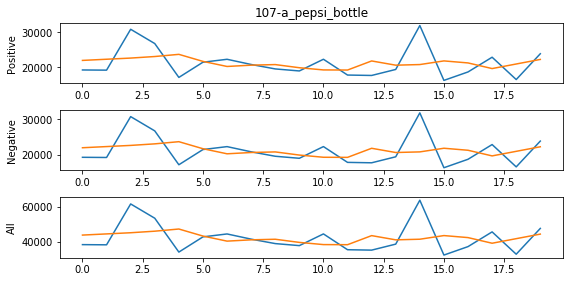

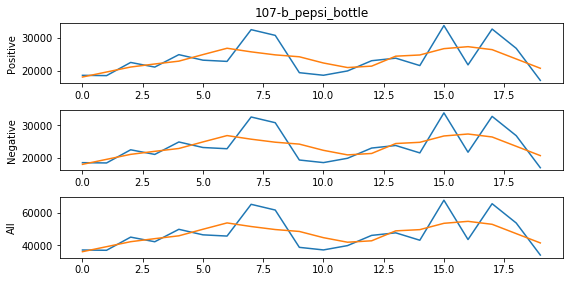

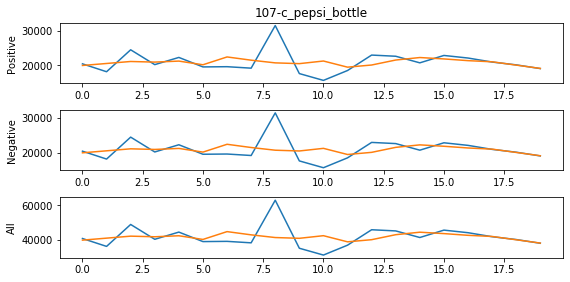

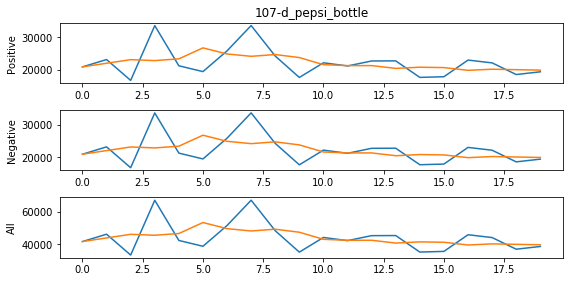

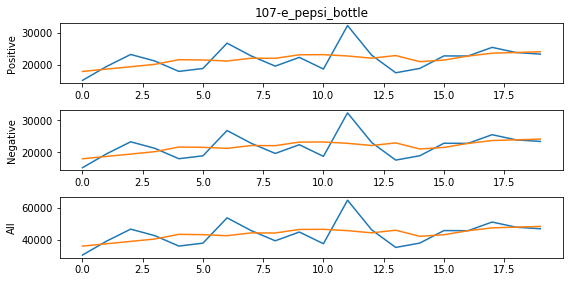

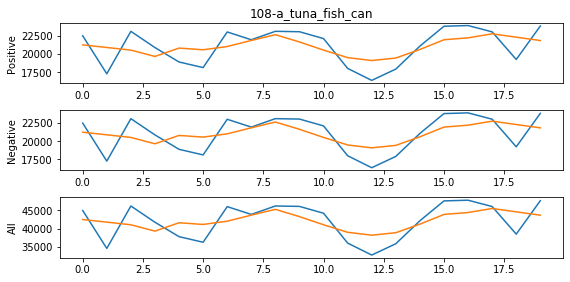

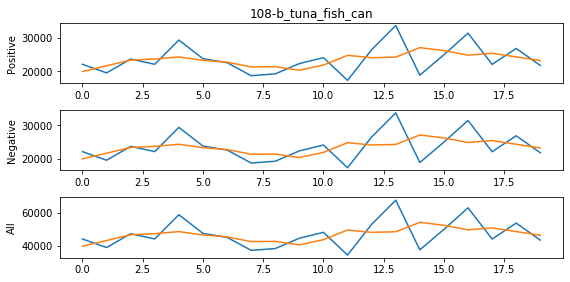

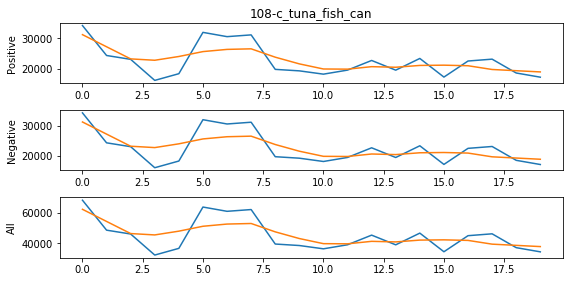

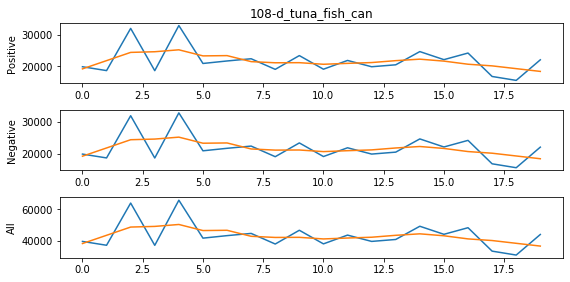

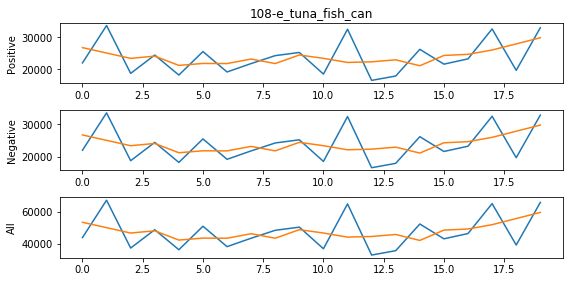

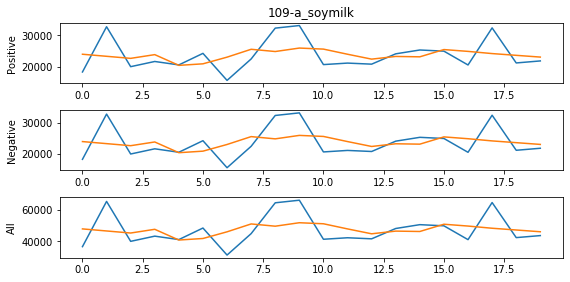

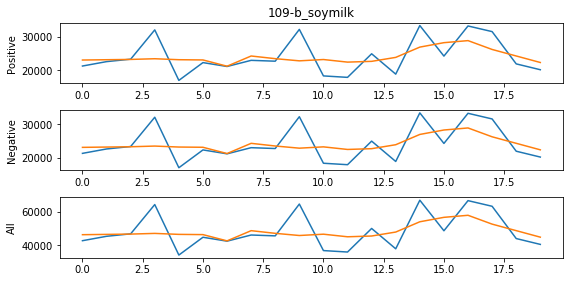

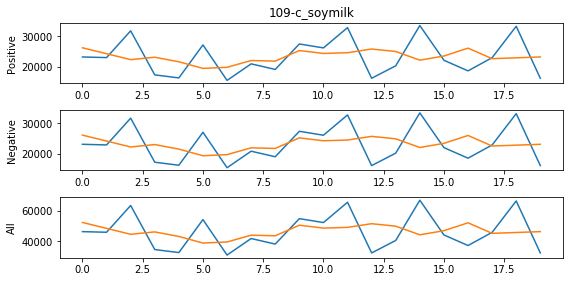

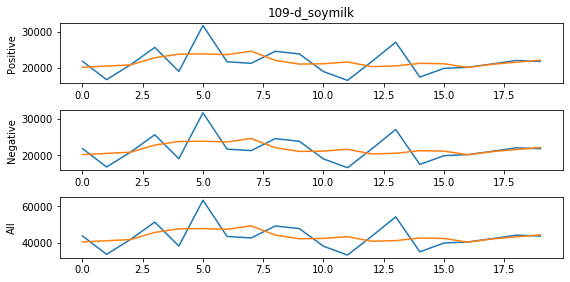

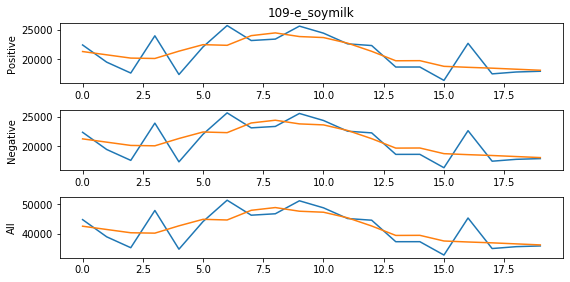

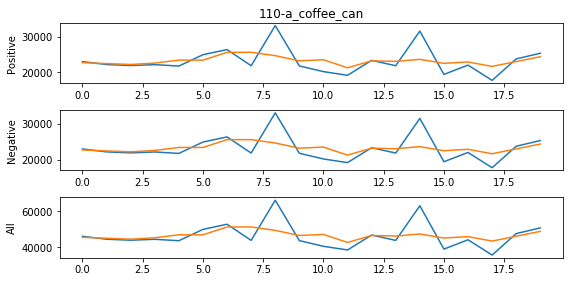

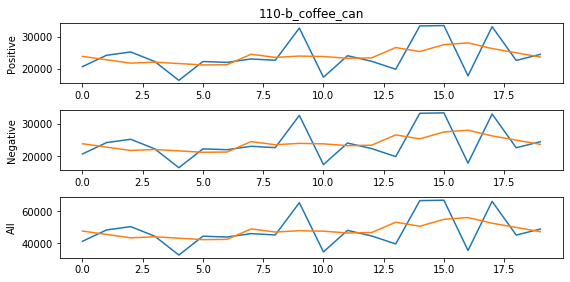

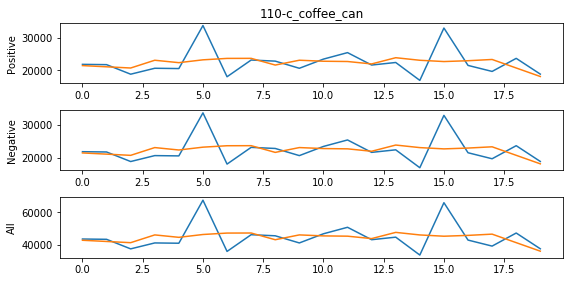

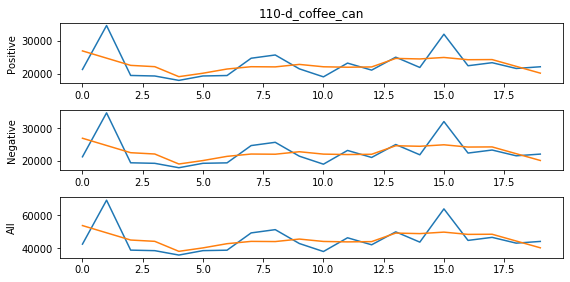

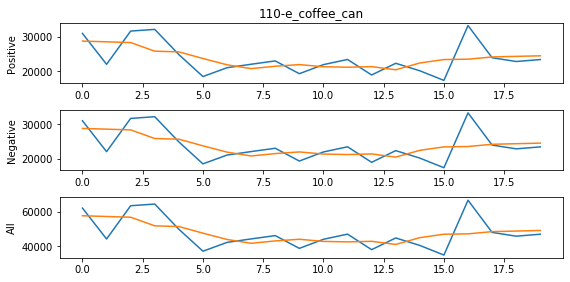

In [127]:
for obj in list_of_objects2:
    mPlot(obj, orders[obj])

In [164]:
tact_spikes = np.array(tact_neg_spikes) + np.array(tact_pos_spikes)

[]

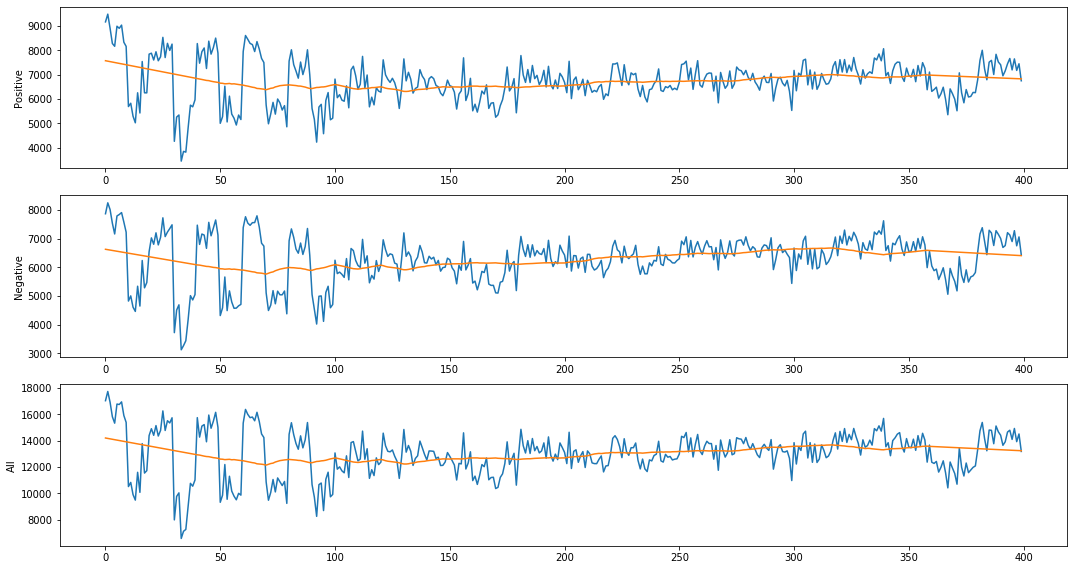

In [165]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(tact_pos_spikes)
ax[0].plot( smooth(tact_pos_spikes) )
ax[0].set_ylabel('Positive')

ax[1].plot(tact_neg_spikes)
ax[1].plot( smooth(tact_neg_spikes) )
ax[1].set_ylabel('Negative')

ax[2].plot(tact_spikes)
ax[2].plot( smooth(tact_spikes) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
# fig.savefig("tactile_full.png")

plt.plot()

In [167]:
tact_spikes_left = np.array(tact_neg_spikes_left) + np.array(tact_pos_spikes_left)

[]

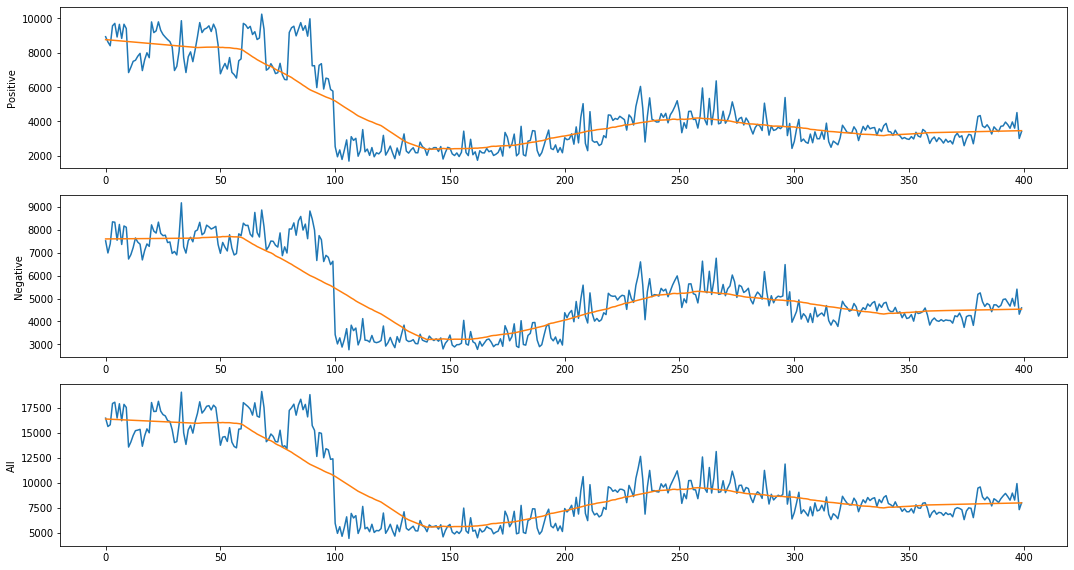

In [168]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(tact_pos_spikes_left)
ax[0].plot( smooth(tact_pos_spikes_left) )
ax[0].set_ylabel('Positive')

ax[1].plot(tact_neg_spikes_left)
ax[1].plot( smooth(tact_neg_spikes_left) )
ax[1].set_ylabel('Negative')

ax[2].plot(tact_spikes_left)
ax[2].plot( smooth(tact_spikes_left) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
# fig.savefig("tactile_full.png")

plt.plot()

In [218]:
tact_spikes_glh = np.array(tact_neg_spikes_glh) + np.array(tact_pos_spikes_glh)

[]

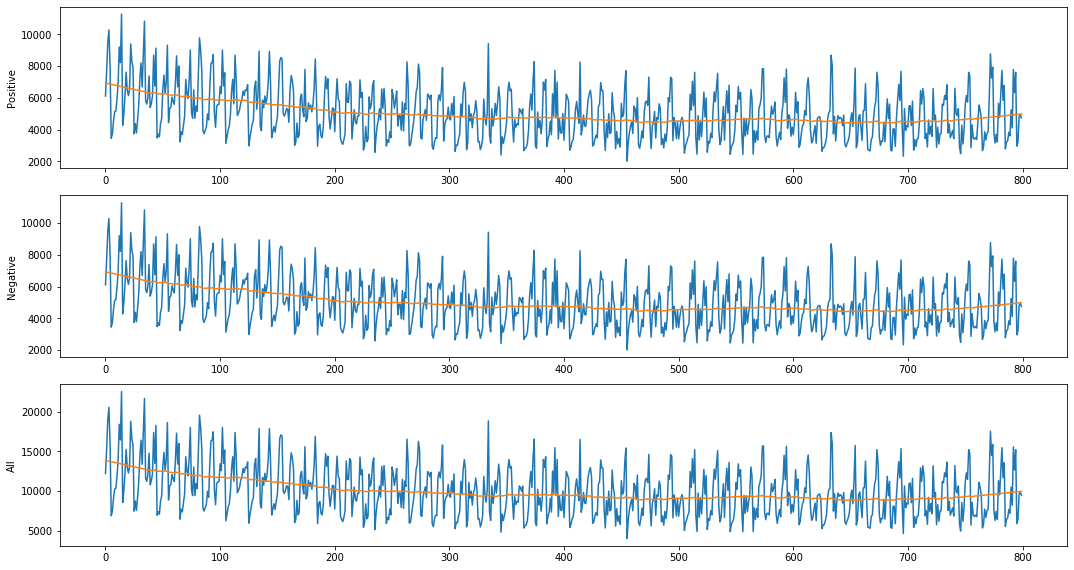

In [238]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(tact_pos_spikes_glh)
ax[0].plot( smooth(tact_pos_spikes_glh) )
ax[0].set_ylabel('Positive')

ax[1].plot(tact_neg_spikes)
ax[1].plot( smooth(tact_pos_spikes_glh) )
ax[1].set_ylabel('Negative')

ax[2].plot(tact_spikes)
ax[2].plot( smooth(tact_spikes) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
fig.savefig("tactile_glh.png")

plt.plot()

In [128]:
cam_spikes = np.array(cam_neg_spikes) + np.array(cam_pos_spikes)

[]

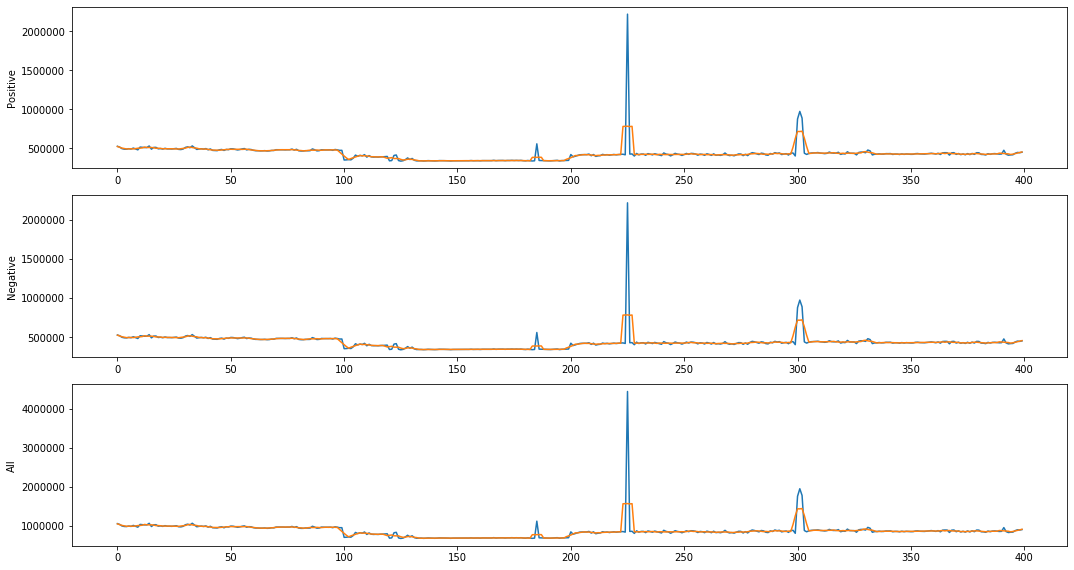

In [129]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(cam_pos_spikes)
ax[0].plot( smooth(cam_pos_spikes) )
ax[0].set_ylabel('Positive')

ax[1].plot(cam_neg_spikes)
ax[1].plot( smooth(cam_neg_spikes) )
ax[1].set_ylabel('Negative')

ax[2].plot(cam_spikes)
ax[2].plot( smooth(cam_spikes) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
fig.savefig("vision_full.png")

plt.plot()

In [229]:
cam_spikes_glh = np.array(cam_neg_spikes_glh) + np.array(cam_pos_spikes_glh)

[]

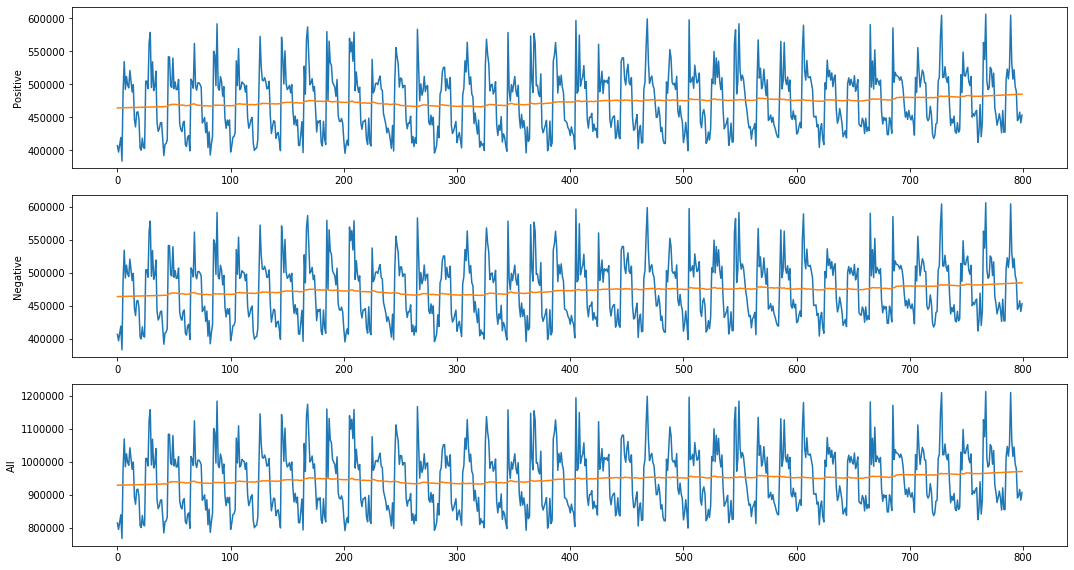

In [240]:
fig, ax = plt.subplots(3, figsize=(15,8))

ax[0].plot(cam_pos_spikes_glh)
ax[0].plot( smooth(cam_pos_spikes_glh) )
ax[0].set_ylabel('Positive')

ax[1].plot(cam_neg_spikes_glh)
ax[1].plot( smooth(cam_neg_spikes_glh) )
ax[1].set_ylabel('Negative')

ax[2].plot(cam_spikes_glh)
ax[2].plot( smooth(cam_spikes_glh) )
ax[2].set_ylabel('All')

plt.tight_layout(True)
fig.savefig("vision_glh.png")

plt.plot()